# Expectation Maximisation: estimating mean and standard deviation

This notebook is based on the videos from Victor Lavrenko (see https://www.youtube.com/watch?v=iQoXFmbXRJA).

## Setup

Suppose we are given two sets of samples, red and blue, drawn from two different [normal distributions](https://en.wikipedia.org/wiki/Normal_distribution). Our goal will be to find the mean and standard deviation for each group of points.

In [1]:
import numpy as np

np.random.seed(110) # for reproducible results

# set the parameters for red and blue distributions we will draw from
red_mean = 3
red_std = 0.8

blue_mean = 7
blue_std = 2

# draw 20 samples from each normal distribution
red = np.random.normal(red_mean, red_std, size=20)
blue = np.random.normal(blue_mean, blue_std, size=20)

both_colours = np.sort(np.concatenate((red, blue))) # array with every sample point (for later use)

Just so it's clear what we working with, let's plot these red and blue groups:

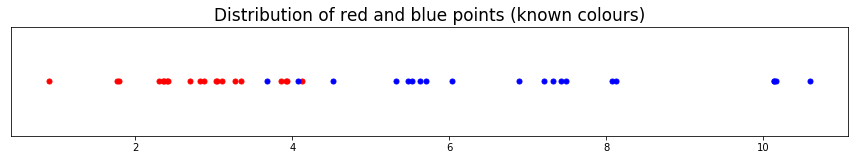

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 2)

plt.plot(red, np.zeros_like(red), '.', color='r', markersize=10);
plt.plot(blue, np.zeros_like(blue), '.', color='b', markersize=10);
plt.title(r'Distribution of red and blue points (known colours)', fontsize=17);
plt.yticks([]);

When we can see the colour of each point, it is very easy to find accurate values for the red mean and the blue mean (and the standard deviation too). In fact we can just pass our arrays of red and blue points to NumPy's built in functions in this case:

In [3]:
np.mean(red)

2.8132116984626867

In [4]:
np.std(red)

0.8001119672360739

In [5]:
np.mean(blue)

6.972553898467638

In [6]:
np.std(blue)

2.0388437926931493

## Hidden colours

Now suppose some malicious actor decides to paint every point purple:

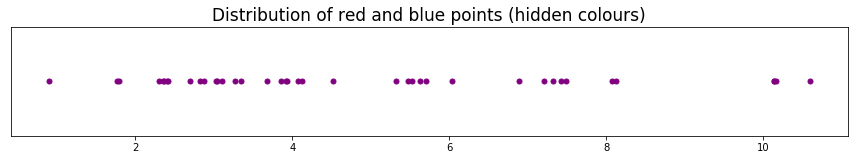

In [7]:
plt.rcParams['figure.figsize'] = (15, 2)

plt.plot(both_colours, np.zeros_like(both_colours), '.', color='purple', markersize=10);
plt.title(r'Distribution of red and blue points (hidden colours)', fontsize=17);
plt.yticks([]);

To our misfortune, we now have *hidden variables*.

We know each point is really *either* red or blue, but the actual colour is not known to us. As such, we don't which values to put into the formulae for the mean and standard deviation. NumPy's built in functions are no longer helpful on their own.

How can we estimate the most likely values for the mean and standard devaition of each group now?

We will use **Expectation Maximisation** to find the best estimates for these values.

## Likelihood function

First we need a [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function). Remember: expectation maximisation is about finding the values the make this function output as large a value as possible given our data points.

We are interested in the probability that the parameters of a distribution, say blue's mean and standard deviation parameters (denoted $B$), are correct given the observed data (denoted $x_i$). In mathematical notation this can be written as the conditional probability:

$$p(B \mid x_i)$$

[Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) tells us that:

$$ p(B \mid x_i) = \frac{p(x_i \mid B)\cdot p(B)}{p(x_i)}$$

We will also assume uniform priors in this example (we think each point is equally likely to be red or blue bfore we see the data because there were equal numbers for each): $p(B) = p(R) = 0.5$. We don't know what $p(x_i)$ is, but we don't need to for our purpose here.

This means:

$$ p(B \mid x_i) = p(x_i \mid B) \cdot k$$

For some contant $k$.

But we will ignore $k$ since likelihood values do need to lie between 0 and 1. This means that our likelihood function can just be:

$$L(B \mid x_i) =  P(x_i \mid B)$$

This probability density function is conveniently available via SciPy's stats module: 

``` python
stats.norm(mean, standard_deviation).pdf(x)
```

For example if the mean of our distribution is 50 and the standard deviation is 15, we can see that we are roughly 10 times more likely to draw the value 61 rather than 84:

In [8]:
from scipy import stats

stats.norm(50, 15).pdf([61, 84])

array([0.02032553, 0.00203781])

## Expectation Maximistation

We know that we have two groups of points, each drawn from a normal distribution. We also have a likelihood function and we would like to find values for the mean and standard deviation that maximise this function (maximum likelihood estimation).

Our approach using will be as follows:

1. Start with initial estimates of the mean and standard deviation for the red and blue groups (these can be anything).
2. Check how likely each (mean, standard deviation) estimate is to produce each sequence each of the data points (using the likelihood function).
3. Produce a weighting for each (mean, stand deviation) pair for each data point. In other words, the greater the weighting the more we believe the point to have been drawn from a distribution with those parameters. These weights will allow us to "rescale" the data points along the axis (the **Expectation** step).
4. Use formulae to compute new maximum likelihood estimates of each paramter based on the rescaled data points (the **Maximisation** step).
5. Repeat steps 2-4 until each parameter estimate has converged, or a set number of iterations has been reached.

Here is a function to compute the weight for each data point (parameters and values are both NumPy arrays):

In [9]:
def weight_of_colour(colour_likelihood, total_likelihood):
    """
    Compute the weight for each colour at each data point.
    """
    return colour_likelihood / total_likelihood

All we need now are functions to estimate the new mean and standard deviation using the weights for Steps 3 and 4 (for more discussion about these functions, see the following section):

In [10]:
def estimate_mean(data, weight):
    """
    For each data point, multiply the point by the probability it
    was drawn from the colour's distribution (its "weight").
    
    Divide by the total weight: essentially, we're finding where 
    the weight is centred among our data points.
    """
    return np.sum(data * weight) / np.sum(weight)

def estimate_std(data, weight, mean):
    """
    For each data point, multiply the point's squared difference
    from a mean value by the probability it was drawn from
    that distribution (its "weight").
    
    Divide by the total weight: essentially, we're finding where 
    the weight is centred among the values for the difference of
    each data point from the mean.
    
    This is the estimate of the variance, take the positive square
    root to find the standard deviation.
    """
    variance = np.sum(weight * (data - mean)**2) / np.sum(weight)
    return np.sqrt(variance)

On to Step 1 of the EM algorithm!

We have no good idea of what the mean and standard deviation might be, so we'll make initial guesses:

In [11]:
# estimates for the mean
red_mean_guess = 1.1
blue_mean_guess = 9

# estimates for the standard deviation
red_std_guess = 2
blue_std_guess = 1.7

How well do these parameters describe our purple data points?

First we'll just define a convenient function for plotting the red and blue bell curves:

In [12]:
def plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=1):
    """
    Plot bell curves for the red and blue distributions given guesses for mean and standard deviation.
    
    alpha : transparency of the plotted curve
    """
    # set figure size and plot the purple dots
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.plot(both_colours, np.zeros_like(both_colours), '.', color='purple', markersize=10)
       
    # compute the size of the x axis
    lo = np.floor(both_colours.min()) - 1
    hi = np.ceil(both_colours.max()) + 1
    x = np.linspace(lo, hi, 500)
    
    # plot the bell curves
    plt.plot(x, stats.norm(red_mean_guess, red_std_guess).pdf(x), color='r', alpha=alpha)
    plt.plot(x, stats.norm(blue_mean_guess, blue_std_guess).pdf(x), color='b', alpha=alpha)
    
    # vertical dotted lines for the mean of each colour - find the height
    # first (i.e. the probability of the mean of the colour group)
    r_height = stats.norm(red_mean_guess, red_std_guess).pdf(red_mean_guess)
    b_height = stats.norm(blue_mean_guess, blue_std_guess).pdf(blue_mean_guess)
    
    plt.vlines(red_mean_guess, 0, r_height, 'r', '--', alpha=alpha)
    plt.vlines(blue_mean_guess, 0, b_height, 'b', '--', alpha=alpha);

Now plot the initial guesses:

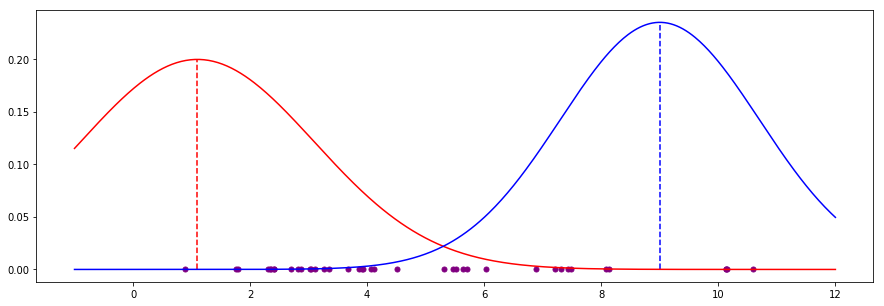

In [13]:
plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess)

These guesses are clearly not good. We knew that each group had an equal number of points, but the mean of each distribution looks to be far off any possible "middle" value.

Let's perform several iterations of Expectation Maximisation to improve these estimates:

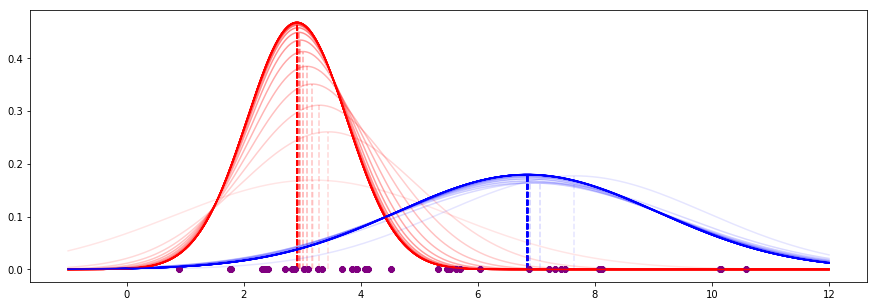

In [14]:
# estimates for the mean
red_mean_guess = 1.1
blue_mean_guess = 9

# estimates for the standard deviation
red_std_guess = 2
blue_std_guess = 1.7

N_ITER = 20 # number of iterations of EM

alphas = np.linspace(0.1, 1, N_ITER) # transparency of curves to plot for each iteration

for i in range(N_ITER):
    
    ## Expectation step
    ## ----------------

    likelihood_of_red = stats.norm(red_mean_guess, red_std_guess).pdf(both_colours)
    likelihood_of_blue = stats.norm(blue_mean_guess, blue_std_guess).pdf(both_colours)

    red_weight = weight_of_colour(likelihood_of_red, likelihood_of_red+likelihood_of_blue)
    blue_weight = weight_of_colour(likelihood_of_blue, likelihood_of_red+likelihood_of_blue)

    ## Maximisation step
    ## -----------------
    
    # N.B. it should not ultimately matter if compute the new standard deviation guess
    # before or after the new mean guess
    
    red_std_guess = estimate_std(both_colours, red_weight, red_mean_guess)
    blue_std_guess = estimate_std(both_colours, blue_weight, blue_mean_guess)

    red_mean_guess = estimate_mean(both_colours, red_weight)
    blue_mean_guess = estimate_mean(both_colours, blue_weight)

    plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=alphas[i])

You should be able to see the shape of each bell curve converging. Let's compare our estimates to the true values for mean and standard deviation: 

In [15]:
from IPython.display import Markdown

md = """
|            | True Mean      | Estimated Mean | True Std.      | Estimated Std. | 
| :--------- |:--------------:| :------------: |:-------------: |:-------------: |
| Red        | {true_r_m:.5f} | {est_r_m:.5f}  | {true_r_s:.5f} | {est_r_s:.5f}  | 
| Blue       | {true_b_m:.5f} | {est_b_m:.5f}  | {true_b_s:.5f} | {est_b_s:.5f}  |
"""

Markdown(
    md.format(
        true_r_m=np.mean(red),
        true_b_m=np.mean(blue),
        
        est_r_m=red_mean_guess,
        est_b_m=blue_mean_guess,
        
        true_r_s=np.std(red),
        true_b_s=np.std(blue),
        
        est_r_s=red_std_guess,
        est_b_s=blue_std_guess,
    )
)


|            | True Mean      | Estimated Mean | True Std.      | Estimated Std. | 
| :--------- |:--------------:| :------------: |:-------------: |:-------------: |
| Red        | 2.81321 | 2.90962  | 0.80011 | 0.85420  | 
| Blue       | 6.97255 | 6.83823  | 2.03884 | 2.22719  |


## About the estimation functions

The functions `estimate_mean()` and `estimate_std()` were crucial to the Expectation step, but no real explanation was offered as to why those computations were performed.

If you've read the first notebook in this repository, you will have seen the discussion about how the redistribution of weight among the data points is key to understanding why EM works and our paramter estimates converge. 

In this example, each point has some red weight and some blue weight.

The `estimate_mean()` function simply looks at the total weight among the datapoints for a particular colour and computes where it is centred on the axis that the data points lie on:

``` python
np.sum(data * weight) / np.sum(weight)
```

Similarly, `estimate_std()` computes the squared values for difference from some central point (`mean`) and works out where the weight of *those* values is centred:

``` python
np.sum(weight * (data - mean)**2) / np.sum(weight)
```

The next time we look at the likelihood of a data point appearing given the parameters, we should see data points that were weighted more towards red that blue become even more strongly weighted towards red. The maximum likelihood estimates will continue to improve until the weight of all points is 1 in favour of either colour. 